Entropy of labels: 5.520427564363666
Gini Index of labels: 0.9756
Best feature index: 6


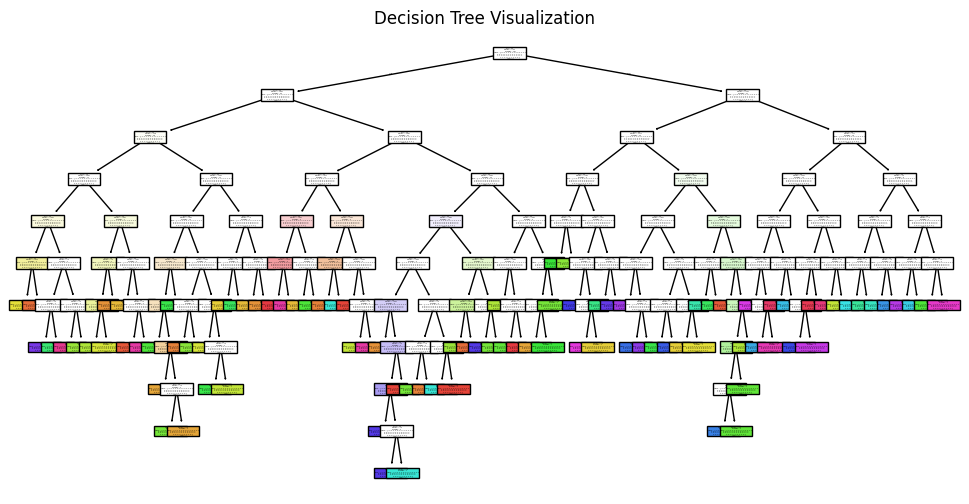

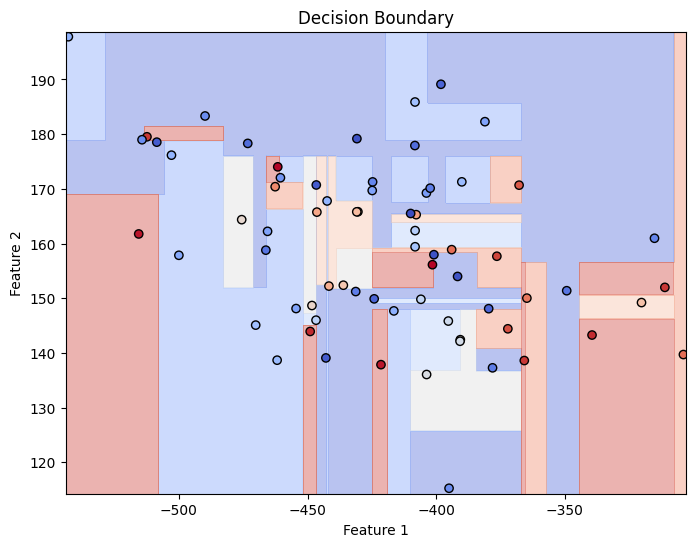

In [ ]:
import os
import numpy as np
import librosa
import math
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# -------------------- A1: Feature Extraction --------------------

def extract_features(file_path):
    y, sr = librosa.load(file_path)
    mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13).T, axis=0)
    zcr = np.mean(librosa.feature.zero_crossing_rate(y).T, axis=0)
    rms = np.mean(librosa.feature.rms(y=y).T, axis=0)
    return np.concatenate((mfccs, zcr, rms))

def load_dataset(folder_path, max_files=100):
    features = []
    labels = []
    files = [f for f in os.listdir(folder_path) if f.endswith(".wav")][:max_files]
    
    for file in files:
        label = file.split("_")[1]  # Assuming label is in filename like 101_s1.wav
        path = os.path.join(folder_path, file)
        feat = extract_features(path)
        features.append(feat)
        labels.append(label)
    
    return np.array(features), np.array(labels)

# -------------------- A1: Entropy & Binning --------------------

def equal_width_binning(data, bins=4):
    min_val, max_val = np.min(data), np.max(data)
    bin_width = (max_val - min_val) / bins
    bin_edges = [min_val + i * bin_width for i in range(bins + 1)]
    return np.digitize(data, bin_edges, right=False)

def calculate_entropy(data):
    total = len(data)
    counts = Counter(data)
    return -sum((count/total) * math.log2(count/total) for count in counts.values())

# -------------------- A2: Gini Index --------------------

def calculate_gini(data):
    total = len(data)
    counts = Counter(data)
    return 1 - sum((count/total)**2 for count in counts.values())

# -------------------- A3 & A4: Binning & Info Gain --------------------

def bin_data(data, bins=4, method='equal_width'):
    if method == 'equal_width':
        return equal_width_binning(data, bins)
    elif method == 'equal_freq':
        sorted_data = np.sort(data)
        bin_edges = [sorted_data[int(len(sorted_data) * i / bins)] for i in range(bins)] + [sorted_data[-1]]
        return np.digitize(data, bin_edges, right=False)
    else:
        raise ValueError("Invalid binning method")

def information_gain(feature, target):
    total_entropy = calculate_entropy(target)
    values = set(feature)
    weighted_entropy = 0
    for val in values:
        subset = [target[i] for i in range(len(feature)) if feature[i] == val]
        weighted_entropy += (len(subset) / len(feature)) * calculate_entropy(subset)
    return total_entropy - weighted_entropy

def find_best_feature(features, target):
    gains = [information_gain(features[:, i], target) for i in range(features.shape[1])]
    return np.argmax(gains)

# -------------------- A5: Decision Tree Construction --------------------

def build_decision_tree(X, y):
    clf = DecisionTreeClassifier(criterion='entropy')
    clf.fit(X, y)
    return clf

# -------------------- A6: Tree Visualization --------------------

def visualize_tree(model, feature_names):
    plt.figure(figsize=(12, 6))
    plot_tree(model, feature_names=feature_names, filled=True, class_names=[str(c) for c in model.classes_])
    plt.title("Decision Tree Visualization")
    plt.show()

# -------------------- A7: Decision Boundary --------------------

def plot_decision_boundary(X, y, model, step=0.1):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    xx, yy = np.meshgrid(np.arange(x_min, x_max, step),
                         np.arange(y_min, y_max, step))

    grid_points = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(grid_points)

    # Ensure Z is numeric
    Z = np.array(Z, dtype=float).reshape(xx.shape)

    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, alpha=0.4, cmap='coolwarm')
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', cmap='coolwarm')
    plt.title("Decision Boundary")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.show()

# -------------------- Main Execution --------------------

def main():
    folder_path = "con_wav"  # Replace with your actual path
    X, y_raw = load_dataset(folder_path, max_files=100)

    # Encode labels to numeric
    le = LabelEncoder()
    y = le.fit_transform(y_raw)

    # Binning
    X_binned = np.array([bin_data(X[:, i], bins=4) for i in range(X.shape[1])]).T

    # Entropy & Gini
    print("Entropy of labels:", calculate_entropy(y))
    print("Gini Index of labels:", calculate_gini(y))

    # Best feature
    best_feat_idx = find_best_feature(X_binned, y)
    print("Best feature index:", best_feat_idx)

    # Decision Tree
    clf = build_decision_tree(X_binned, y)
    visualize_tree(clf, [f"F{i}" for i in range(X.shape[1])])

    # Decision Boundary (first 2 features)
    X2 = X[:, :2]
    X2_train, _, y_train, _ = train_test_split(X2, y, test_size=0.3, random_state=42)
    clf2 = DecisionTreeClassifier().fit(X2_train, y_train)
    plot_decision_boundary(X2_train, y_train, clf2)

if __name__ == "__main__":
    main()